### Previsão de Mortes Neonatal

Neste projeto, vamos utilizar dados públicos do SINASC (Sistema de Nascidos Vivos) e do SIM (Sistema de Mortalidade) para construir modelos de aprendizado de máquina capazes de prever o risco de morte neonatal (até 28 dias após o nascimento).

*Alunos:*
- Júlia Moraes
- Luiz Eduardo

Imports necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### 1. Tratamentos básico dos dados para o Aprendizado

##### 1.1 Construindo matriz X e vetor y

In [2]:
df = pd.read_csv('sinasc_balanceado.csv', low_memory=False)

In [3]:
# dados númericos
num_cols = ['idade_mae', 'peso', 'semanas_gestacao', 'num_gestacao',
            'partos_normais', 'partos_cesareos', 'mes_inicio_prenatal', 'qntd_filvivos', 'qntd_filmortos']

# dados ordinais
ord_cols = ['consultas_prenatal', 'indice_kotelchuck', 'escolaridade_mae']

# dados categóricos
cat_cols = ['tipo_gravidez', 'tipo_parto', 'parto_induzido', 'cesarea_antes',
            'racacor_mae', 'racacor_bebe', 'paridade', 'anomalia_identificada',
            'prenatal_inadequado', 'poucas_consultas', 'prenatal_tardio']

In [4]:
# Transformar 9 ou outros ignorados em NaN
df.replace(9, pd.NA, inplace=True)

In [5]:
#Pipeline de pré-processamento

# Numéricas: imputar média e padronizar
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # valores vazios vira média
    ('scaler', StandardScaler()) # normaliza
])

# Ordinais: imputar mais frequente e codificar como dummies
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # valores vazios vira moda
])

# Categóricas: imputar mais frequente e codificar dummies
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # valores vazios vira moda
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # codifica dummies
]) # exemplo: tipo_parto_vaginal, tipo_parto_cesarea recebe 0 ou 1 

# Combinar
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ord', ord_transformer, ord_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [6]:
y = df['obitos_1m']
X = df.drop(columns=['obitos_1m'])

In [7]:
# Verificar valores nulos nas colunas numéricas
print("Valores nulos nas colunas numéricas:")
for col in num_cols:
    if col in X.columns:
        print(f"{col}: {X[col].isnull().sum()}")

# Substituir pd.NA por np.nan para compatibilidade com sklearn
X = X.replace({pd.NA: np.nan})

Valores nulos nas colunas numéricas:
idade_mae: 2
peso: 29
semanas_gestacao: 585
num_gestacao: 1621
partos_normais: 2214
partos_cesareos: 2237
mes_inicio_prenatal: 2220
qntd_filvivos: 1714
qntd_filmortos: 2432


C:\Users\julja\AppData\Local\Temp\ipykernel_29216\1250505372.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({pd.NA: np.nan})


In [8]:
X_processed = preprocessor.fit_transform(X)

##### 1.2 Número de amostras e parametros 

In [9]:
N, p = X_processed.shape

print(f"Número de amostras (N): {N}")
print(f"Número de parâmetros (p): {p}")

Número de amostras (N): 44958
Número de parâmetros (p): 42


##### 1.3 Separar em treino e teste

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [11]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### 2. REDES NEURAIS

##### 2.1 Definindo arquitetura da rede neural

Para calcularmos o número máximo de neurônios por camada fazemos a substituição na seguinte fórmula: 
𝑛 ≤ 𝐶𝑇−10/10(𝑑+2)
Substiutuindo, teremos aproximadamente 59 como limite de neurônios por camada.

In [12]:
BATCH_SIZE = 32
EPOCHS = 100
RANDOM_STATE = 2

Testando primeira rede neural

In [13]:
# Criando a arquitetura da rede neural inicial 
model = Sequential()

model.add(Dense(64, input_dim=42, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(16,kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1,kernel_initializer='he_normal', activation='sigmoid'))

# Instanciação e configuração de otimizadores
sgd = optimizers.SGD(learning_rate=0.01)

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=BATCH_SIZE)

c:\Users\julja\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6642 - loss: 0.6214 - val_accuracy: 0.6674 - val_loss: 0.6203
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6662 - loss: 0.6064 - val_accuracy: 0.6696 - val_loss: 0.6155
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6699 - loss: 0.6016 - val_accuracy: 0.5609 - val_loss: 0.6839
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6704 - loss: 0.5994 - val_accuracy: 0.6753 - val_loss: 0.6034
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6736 - loss: 0.5972 - val_accuracy: 0.6825 - val_loss: 0.5947
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6750 - loss: 0.5955 - val_accuracy: 0.6815 - val_loss: 0.5953
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6765 - loss: 0.5942 - val_accuracy: 0.6779 - val_loss: 0.5950
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6790 - loss: 0.5927 - val

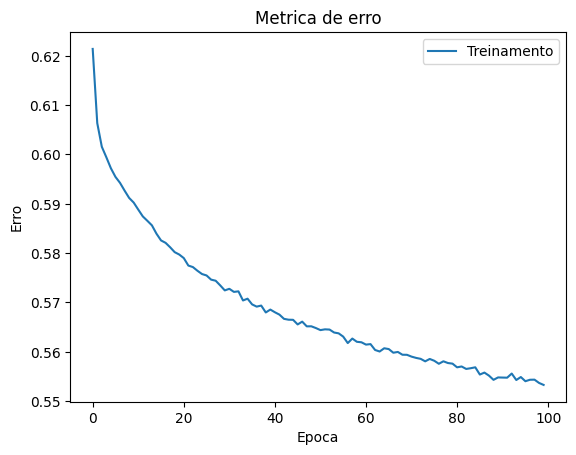


--> Acuracia (treino): 0.7147
--> Acuracia (teste): 0.7026
--> E_out - E_in = 0.0199
--> acc_train - acc_test = 0.0121


In [14]:
plt.plot(history.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de teste
E_out, acc_test = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (teste): {acc_test:.4f}')
print(f"--> E_out - E_in = {E_out - E_in:.4f}")
print(f"--> acc_train - acc_test = {acc_train - acc_test:.4f}")

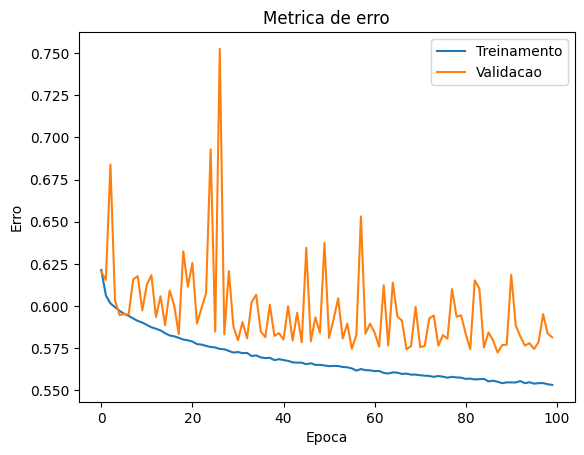

--> E_val - E_in = 0.0254
--> Acuracia (treino): 0.7147
--> Acuracia (validacao): 0.6957
--> acc_train - acc_val = 0.0190


In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de validacao
E_val, acc_val = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print(f"--> E_val - E_in = {E_val - E_in:.4f}")
print(f'--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")

Testando segunda rede neural

In [16]:
# Criando a arquitetura da rede neural inicial 
model = Sequential()

model.add(Dense(32, input_dim=42, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

# Instanciação e configuração de otimizadores
sgd = optimizers.SGD(learning_rate=0.01)

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6517 - loss: 0.6653 - val_accuracy: 0.6669 - val_loss: 0.6340
Epoch 2/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6663 - loss: 0.6361 - val_accuracy: 0.6675 - val_loss: 0.6297
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6671 - loss: 0.6324 - val_accuracy: 0.6674 - val_loss: 0.6277
Epoch 4/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6669 - loss: 0.6308 - val_accuracy: 0.6672 - val_loss: 0.6249
Epoch 5/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6671 - loss: 0.6295 - val_accuracy: 0.6672 - val_loss: 0.6232
Epoch 6/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6667 - loss: 0.6253 - val_accuracy: 0.6675 - val_loss: 0.6193
Epoch 7/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6673 - loss: 0.6247 - val_accuracy: 0.6671 - val_loss: 0.6156
Epoch 8/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6680 - loss: 0.6200 - val

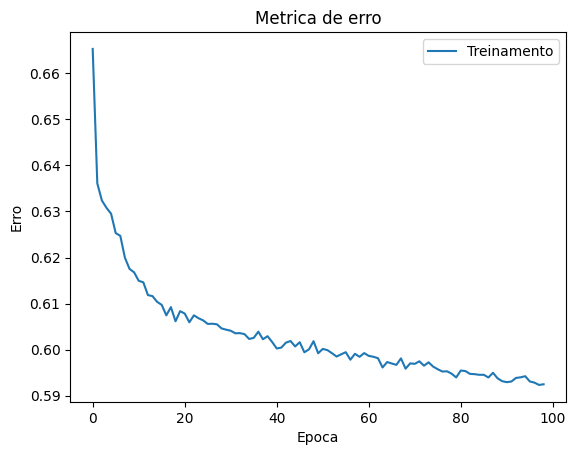


--> Acuracia (treino): 0.6868
--> Acuracia (teste): 0.6864
--> E_out - E_in = 0.0012
--> acc_train - acc_test = 0.0005


In [17]:
plt.plot(history.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de teste
E_out, acc_test = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (teste): {acc_test:.4f}')
print(f"--> E_out - E_in = {E_out - E_in:.4f}")
print(f"--> acc_train - acc_test = {acc_train - acc_test:.4f}")

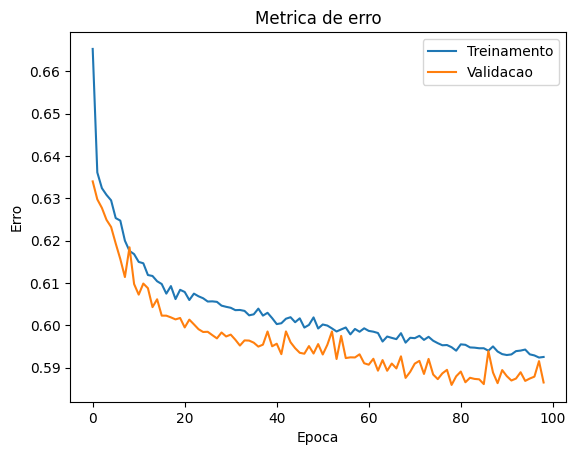

--> E_val - E_in = 0.0010
--> Acuracia (treino): 0.6868
--> Acuracia (validacao): 0.6853
--> acc_train - acc_val = 0.0016


In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de validacao
E_val, acc_val = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print(f"--> E_val - E_in = {E_val - E_in:.4f}")
print(f'--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")

In [19]:
y_pred = model.predict(X_test)

# Converter probabilidades em classes (0 ou 1)
y_pred_classes = (y_pred > 0.5).astype(int)

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


In [20]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.69      0.96      0.80      5976
           1       0.65      0.14      0.23      3016

    accuracy                           0.69      8992
   macro avg       0.67      0.55      0.52      8992
weighted avg       0.68      0.69      0.61      8992



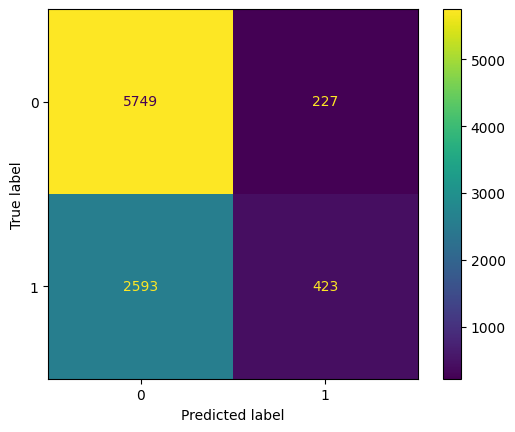

In [21]:
cm = confusion_matrix(y_test, y_pred_classes, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()

Ambos os modelos estao bem ajustados, porém a superioridade na generalização do segundo modelo é mais valiosa que a pequena vantagem em acurácia do primeiro modelo.

#### 3. Árvores de decisão

##### 3.1 Construindo a árvore de decisão

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [23]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

print("Ein: %0.4f" % (1 - accuracy_score(y_train, clf.predict(X_train)) ))
print("Eout: %0.4f" % (1 - accuracy_score(y_test, clf.predict(X_test)) ))

print(classification_report(y_test, clf.predict(X_test)))

Ein: 0.0001
Eout: 0.3710
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      5976
           1       0.45      0.48      0.46      3016

    accuracy                           0.63      8992
   macro avg       0.59      0.59      0.59      8992
weighted avg       0.63      0.63      0.63      8992



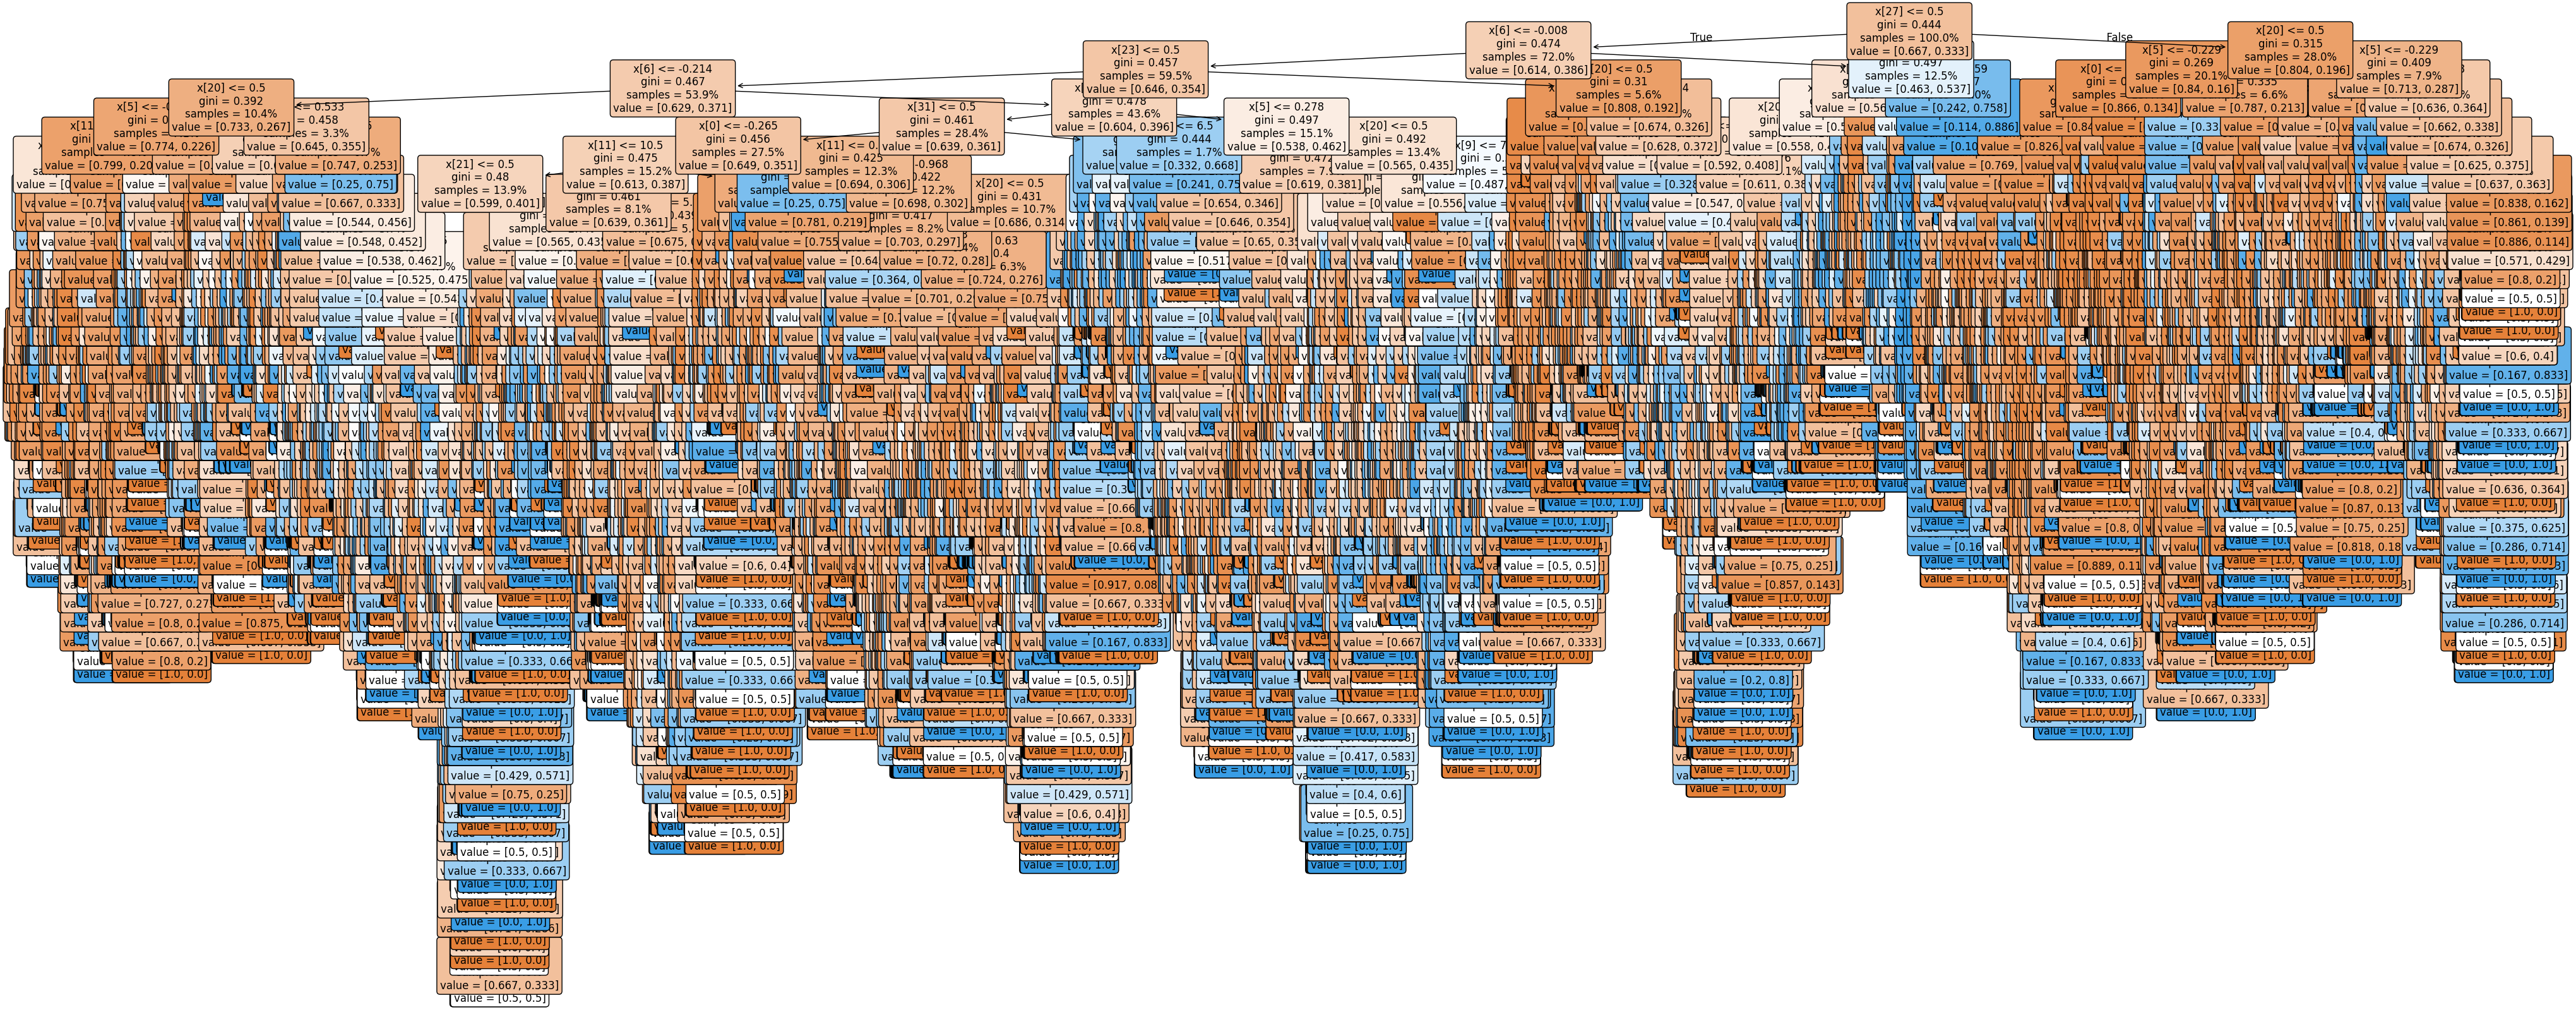

In [24]:
#Desenho da árvore
plt.figure(figsize=(50,20))
plot_tree(
    clf,
    filled=True, 
    proportion = True,
    fontsize=12, 
    rounded = True)
plt.show()

[0.00000000e+00 7.20845407e-06 8.34121114e-06 ... 5.72325055e-03
 6.92967372e-03 1.45712767e-02]
[1.11216149e-04 1.32841511e-04 1.49523933e-04 ... 4.22596949e-01
 4.29526623e-01 4.44097900e-01]


C:\Users\julja\AppData\Local\Temp\ipykernel_29216\889613658.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


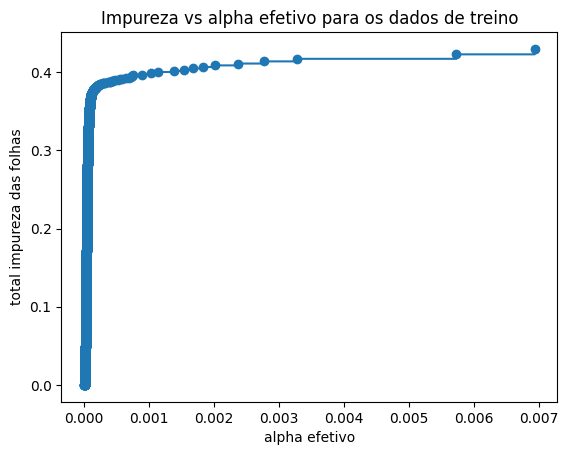

In [25]:
#Recupera os valores efetivos de alpha para a elaboração da fase de prunning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#Plota a relação entre os valores de alpha e impureza das folhas
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("alpha efetivo")
ax.set_ylabel("total impureza das folhas")
ax.set_title("Impureza vs alpha efetivo para os dados de treino")
fig.show()

print(ccp_alphas)
print(impurities)

In [26]:
if len(ccp_alphas) > 30:
    ccp_alphas = np.linspace(ccp_alphas.min(), ccp_alphas.max(), 30)

param_grid = {'ccp_alpha': ccp_alphas}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 10, verbose=2, n_jobs=-1)
CV_clf.fit(X_train, y_train)  


print('Ein: %0.4f' % (1 - accuracy_score(y_train, CV_clf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_test, CV_clf.predict(X_test))))
print(classification_report(y_test, CV_clf.predict(X_test)))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Ein: 0.2930
Eout: 0.2954
              precision    recall  f1-score   support

           0       0.72      0.91      0.80      5976
           1       0.62      0.30      0.41      3016

    accuracy                           0.70      8992
   macro avg       0.67      0.60      0.60      8992
weighted avg       0.69      0.70      0.67      8992



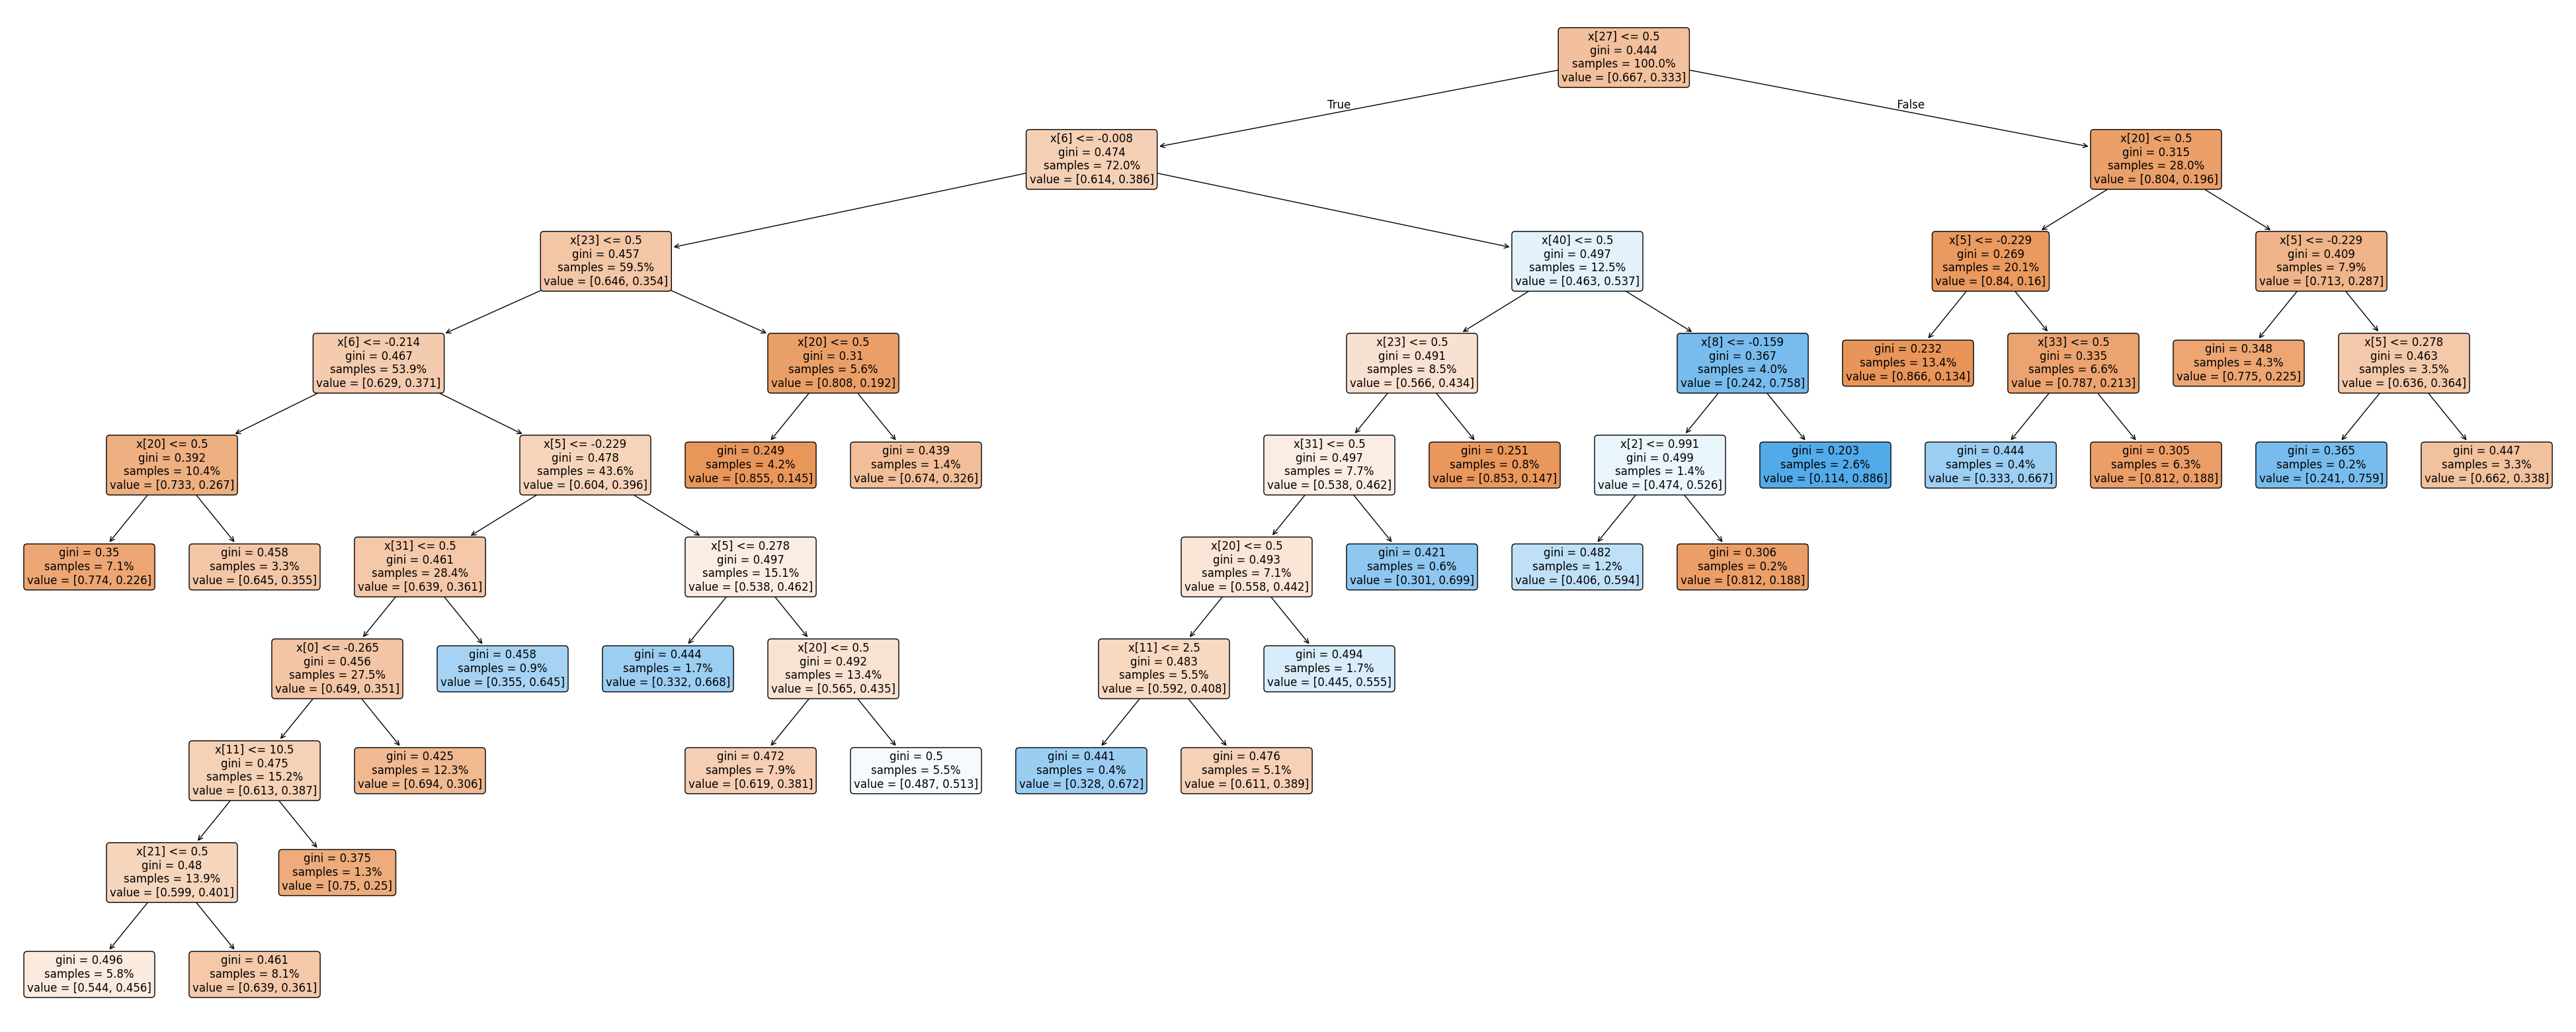

Melhor alpha: 0.0005024578173488862
Acurácia treino: 0.7070010565534115
Acurácia teste: 0.7046263345195729


In [27]:
# 7. Treinar melhor árvore
best_clf = CV_clf.best_estimator_

#Desenho da árvore
plt.figure(figsize=(50,20))
plot_tree(
    best_clf,
    filled=True, 
    proportion = True,
    fontsize=12, 
    rounded = True)
plt.show()


print("Melhor alpha:", CV_clf.best_params_['ccp_alpha'])
print("Acurácia treino:", accuracy_score(y_train, best_clf.predict(X_train)))
print("Acurácia teste:", accuracy_score(y_test, best_clf.predict(X_test)))

In [28]:
feature_names = preprocessor.get_feature_names_out()
print("Coluna 7:", feature_names[6])

Coluna 7: num__mes_inicio_prenatal


In [29]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

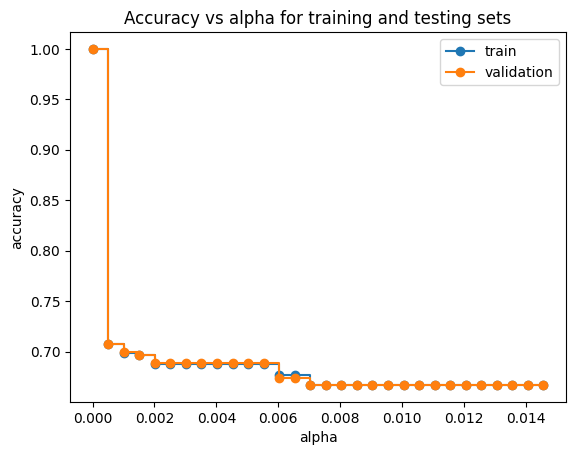

In [30]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="validation", drawstyle="steps-post")
ax.legend()
plt.show()

In [31]:
y_pred_arvore = best_clf.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred_arvore))

              precision    recall  f1-score   support

           0       0.72      0.91      0.80      5976
           1       0.62      0.30      0.41      3016

    accuracy                           0.70      8992
   macro avg       0.67      0.60      0.60      8992
weighted avg       0.69      0.70      0.67      8992



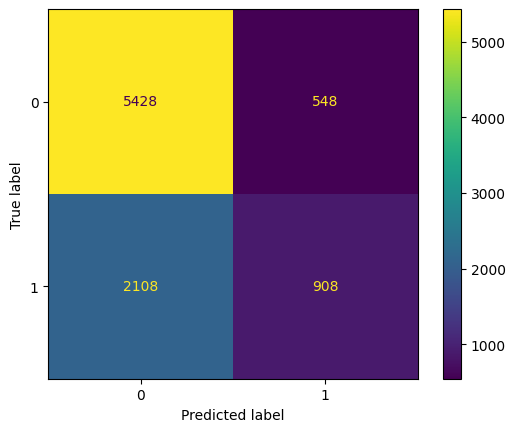

In [33]:
cm = confusion_matrix(y_test, y_pred_arvore, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()

#### 4. SVM

In [34]:
#from sklearn.svm import SVC

#param_grid = {'C': [1, 5, 10, 50],
#             'gamma': [0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]}
#grid_svm = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, cv=5)

#%time grid_svm.fit(X_train, y_train)
#print(grid_svm.best_params_)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [36]:
# Definir os parâmetros do SVM
param_grid = {'C': [50], 'gamma': [0.01]}

# Criar o modelo SVM
svm_model = SVC(kernel='rbf', C=50, gamma=0.01, random_state=42)

# Treinar o modelo
svm_model.fit(X_train, y_train)

# Fazer predições no conjunto de teste
y_pred_svm = svm_model.predict(X_test)

print('Ein: %0.4f' % (1 - accuracy_score(y_train, svm_model.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_test, svm_model.predict(X_test))))

Ein: 0.2823
Eout: 0.2919


In [37]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.71      0.96      0.81      5976
           1       0.71      0.22      0.33      3016

    accuracy                           0.71      8992
   macro avg       0.71      0.59      0.57      8992
weighted avg       0.71      0.71      0.65      8992



In [38]:
y_pred_binary = y_pred_svm.astype(int)

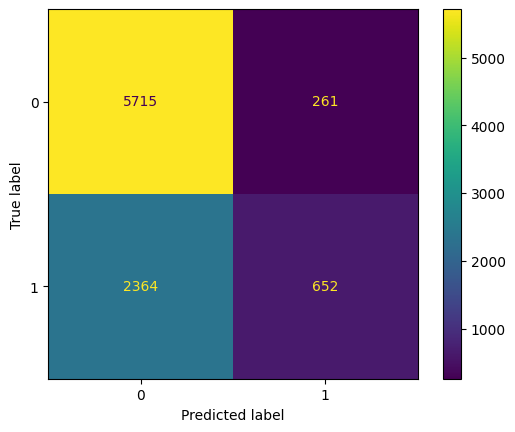

In [39]:
cm = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()